# Chapter 7 - Using gate-based Quantum Computers - Some basic quantum algorithms 
1.Oracle and Grover’s Search


© 2021, 2022 Packt Publishing

Written by Alex Khan

In [3]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [5]:
from braket.circuits import Circuit, Gate, Observable, Instruction
from braket.devices import LocalSimulator
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from braket.aws import AwsDevice

In [7]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [8]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [9]:
def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Advantage_system1.1','DW_2000Q_6','Aspen-9','IonQ Device']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [10]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [11]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [12]:
# this function has been updated from the function in past chapters
def run_circuit(circuit, local=True, device_name='', s3_folder='', display_binary=False):
    import matplotlib.pyplot as plt
    %matplotlib inline
    if local==True:
        device = LocalSimulator()
        result = device.run(circuit, shots=1000).result()
    else:
        measured_qubits=len(circuit.qubits)
        device=set_device(device_name)
        num_reads=estimate_cost_measured_qubits(device,measured_qubits)
        print('device', device)
        print('num reads', num_reads)
        result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder).result()
        actual_simulator_cost(device, result)
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.xlabel('states');
        plt.ylabel('counts');
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(i)
        for i in range(len(x_val)):
            dec_counts[x_val[i]]=y_val[i]
        print(dec_counts)
        plt.bar(x_val, y_val)

        plt.xlabel('states');
        plt.ylabel('counts');
    
    return(result)

In [13]:
def run_circuit_local(circ):
    import numpy as np
    # This function prints the quantum circuit and calculates the final state vector
    # This can be used for multiple qubits and only uses the local simulator
    # The Bloch sphere is not printed
    circ=circ.state_vector()
    print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()

    arr_r=np.array(result.values).T
    print(arr_r)
    return(arr_r)

In [14]:
def query_circuit_db(db, n, m, limit=0, local=True, device_name=""):
    import numpy as np
    def Us(dim):
        Us=np.zeros((dim, dim))
        for i in range(dim):
            Us[i,i]=1
        Us[dim-1,dim-1]=-1
        return(Us)
    

    ccz=Circuit().cnot(1,2).ti(2).cnot(0,2).t(2).cnot(1,2).ti(2).cnot(0,2).t(1).t(2).cnot(0,1).t(0).ti(1).cnot(0,1)

    cccz=Circuit()
    cccz=cccz.rz(0,np.pi/16).cnot(0,1).rz(1,-np.pi/16).cnot(0,1).rz(1,np.pi/16)
    cccz=cccz.cnot(1,2).rz(2,-np.pi/16).cnot(0,2).rz(2,np.pi/16).cnot(1,2).rz(2,-np.pi/16).cnot(0,2).rz(2,np.pi/16)
    cccz=cccz.cnot(2,3).rz(3,-np.pi/16).cnot(0,3).rz(3,np.pi/16).cnot(1,3).rz(3,-np.pi/16).cnot(0,3).rz(3,np.pi/16)
    cccz=cccz.cnot(2,3).rz(3,-np.pi/16).cnot(0,3).rz(3,np.pi/16).cnot(1,3).rz(3,-np.pi/16).cnot(0,3).rz(3,np.pi/16)
    
    
    
    print(db)
    #print('total size',dim)
    print('qubits',n)
    if limit==0:
        repeat=int(((2**n)/m)**(0.5))-1
    else:
        repeat=limit
        
    print('db reads',repeat)
    Us=Us(2**n)
    #print(Us)
    grover=Circuit()
    targets=[]
    for i in range (n):
        grover.h(i)
        targets.append(i)
    #print('2 ** len targets',2**len(targets), len(db))
    for i in range (repeat):
        grover.add(db)
        grover.h(targets)
        grover.x(targets)
        if n==2:
            grover.cz(0,1)
        elif n==3:
            grover.add(ccz)
            
        elif n==4:
            grover.add(cccz)
        else:
            grover.unitary(matrix=Us, targets=targets, display_name="Us")
        
        grover.x(targets)
        grover.h(targets)
    print(grover)
    
    if n!=2:
        local=True
    
    if local==True:
        result=run_circuit(grover)
    else:
        result=run_circuit(grover, False, device_name, s3_folder)
    
    return(result)

### 1. Grover's search algorithm

In [32]:
def init_db(n):
    import numpy as np
    dim=2**n

    db=np.zeros((dim, dim))
    for i in range(dim):
        db[i,i]=1
    print('range= 0 to ',dim-1) 
    
    return(db,dim)

In [33]:
def db_save(db, N):
    db[N,N]=-1
    return(db)

In [34]:
def insert_db(values, db):
    import numpy as np
    m=0
    dim=len(db)
    for i in values:
        if i < dim:
            db_save(db, i)
            print(i, "added to db")
            m+=1
        else:
            print(i, 'is too large, ignored')

    db = np.array(db)
    return(db, m)


In [86]:
def query_db(db, n, m, limit=0, local=True, device_name=""):
    import numpy as np
    def Us(dim):
        Us=np.zeros((dim, dim))
        for i in range(dim):
            Us[i,i]=1
        Us[dim-1,dim-1]=-1
        return(Us)
    
    dim=len(db)
    print('total size',dim)
    print('qubits',n)
    if limit==0:
        repeat=int(np.floor(((2**n)/m)**(0.5)))
    else:
        repeat=limit
    print('db reads',repeat)
    Us=Us(dim)
    #print(Us)
    grover=Circuit()
    targets=[]
    for i in range (n):
        grover.h(i)
        targets.append(i)
    #print('2 ** len targets',2**len(targets), len(db))
    for i in range (repeat):
        grover.unitary(matrix=db, targets=targets, display_name="db")
        grover.h(targets)
        grover.x(targets)
        grover.unitary(matrix=Us, targets=targets, display_name="Us")
        grover.x(targets)
        grover.h(targets)
    #print(grover)
    
    if local==True:
        result=run_circuit(grover)
    else:
        result=run_circuit(grover, False, device_name, s3_folder)
    
    return(result)

In [75]:
Qubits=2
db, dim=init_db(Qubits)
print(db)

range= 0 to  3
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [76]:
db, m = insert_db([3],db)
print(db)

3 added to db
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]


total size 4
qubits 2
db reads 1
{3: 1000}


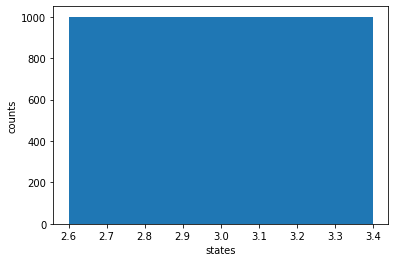

In [77]:
result=query_db(db, Qubits, m ,1)

In [78]:
Qubits=8
db, dim=init_db(Qubits)
db, m = insert_db([0, 15, 16, 41, 140, 200, 255], db)
print('total hidden values',m)

range= 0 to  255
0 added to db
15 added to db
16 added to db
41 added to db
140 added to db
200 added to db
255 added to db
total hidden values 7


In [79]:
print(db)

[[-1.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ...  0.  1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]


total size 256
qubits 8
db reads 1
{168: 3, 254: 2, 255: 37, 191: 5, 116: 4, 140: 29, 229: 3, 16: 31, 200: 45, 217: 3, 93: 4, 72: 7, 230: 7, 42: 3, 13: 4, 41: 22, 249: 7, 143: 6, 37: 5, 84: 4, 128: 5, 198: 3, 137: 2, 80: 2, 63: 4, 38: 3, 244: 4, 21: 1, 2: 6, 196: 1, 15: 23, 29: 3, 248: 5, 235: 6, 182: 4, 57: 4, 218: 4, 162: 2, 148: 3, 206: 5, 69: 5, 90: 4, 45: 2, 165: 5, 225: 2, 20: 3, 167: 4, 174: 4, 105: 1, 177: 4, 147: 4, 88: 3, 62: 3, 14: 8, 95: 5, 4: 7, 24: 5, 5: 4, 108: 3, 120: 7, 117: 3, 0: 39, 73: 5, 39: 3, 133: 3, 251: 2, 145: 5, 48: 2, 233: 6, 33: 4, 211: 4, 75: 3, 70: 3, 27: 6, 163: 3, 53: 2, 60: 1, 153: 4, 66: 8, 109: 2, 223: 3, 47: 3, 87: 3, 195: 3, 56: 4, 173: 3, 149: 4, 175: 4, 23: 2, 36: 3, 243: 2, 127: 5, 78: 1, 1: 2, 77: 3, 99: 6, 40: 2, 234: 5, 141: 4, 202: 8, 55: 2, 35: 3, 113: 6, 122: 5, 227: 1, 104: 1, 52: 2, 219: 2, 178: 2, 154: 1, 22: 7, 144: 2, 74: 3, 68: 1, 253: 2, 184: 4, 222: 2, 213: 2, 6: 3, 123: 5, 156: 7, 51: 7, 82: 3, 183: 5, 94: 3, 138: 3, 228: 3, 186: 

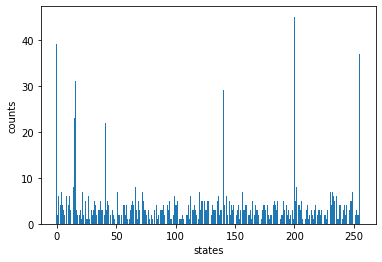

In [80]:
# run on local simulator
result=query_db(db, Qubits, m ,1)

In [81]:
available_devices()

['Advantage_system4.1', 'DW_2000Q_6', 'IonQ Device', 'SV1', 'TN1', 'dm1']

In [87]:
Qubits=7
db, dim=init_db(Qubits)
db, m = insert_db([0, 15, 16, 41, 140, 200, 255], db)
print('total hidden values',m)

range= 0 to  127
0 added to db
15 added to db
16 added to db
41 added to db
140 is too large, ignored
200 is too large, ignored
255 is too large, ignored
total hidden values 4


total size 128
qubits 7
db reads 4
Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
max shots: 100000
for 7 measured qubits the number of shots recommended: 3,200
simulator cost per  minute : $ 0.075
total cost cannot be estimated
device Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)
num reads 3200
simulator cost per  minute : $ 0.075
total execution time:  483 ms
total cost estimated: $ 0.00060375
{41: 805, 15: 779, 16: 815, 0: 800, 88: 1}


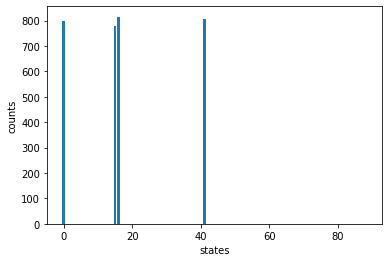

In [89]:
result=query_db(db, Qubits, m, 0, False, 'SV1' )

## Amplitude amplification using quantum circuits and execution on a quantum device

In [176]:
db=Circuit().cz(0,1)
print(db)

T  : |0|
        
q0 : -C-
      | 
q1 : -Z-

T  : |0|


T  : |0|
        
q0 : -C-
      | 
q1 : -Z-

T  : |0|
qubits 2
db reads 1
T  : |0|1|2|3|4|5|6|
                    
q0 : -H-C-H-X-C-X-H-
        |     |     
q1 : -H-Z-H-X-Z-X-H-

T  : |0|1|2|3|4|5|6|
{3: 1000}


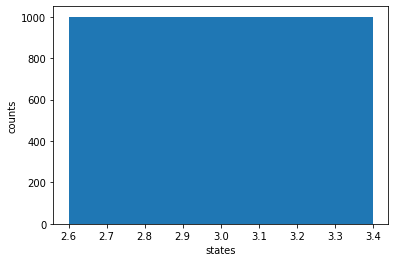

In [175]:
result=query_circuit_db(db, 2, 1)

In [180]:
db=Circuit().cz(0,1).cz(0,2)
print(db)

T  : |0|1|
          
q0 : -C-C-
      | | 
q1 : -Z-|-
        | 
q2 : ---Z-

T  : |0|1|


T  : |0|1|
          
q0 : -C-C-
      | | 
q1 : -Z-|-
        | 
q2 : ---Z-

T  : |0|1|
qubits 3
db reads 1
T  : |0|1| 2 |3|4|5|6 |7|8|9|10|11|12|13|14|15|16|
                                                  
q0 : -H-C-C---H-X------C--------C--C--T--C--X--H--
        | |            |        |  |     |        
q1 : -H-Z-|-H-X---C----|---C-T--|--X--Ti-X--X--H--
          |       |    |   |    |                 
q2 : -H---Z---H-X-X-Ti-X-T-X-Ti-X--T--X--H--------

T  : |0|1| 2 |3|4|5|6 |7|8|9|10|11|12|13|14|15|16|
{5: 487, 6: 513}


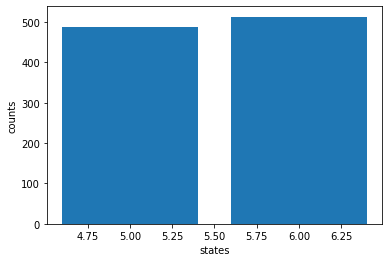

In [193]:
result=query_circuit_db(db, 3, 2)

In [46]:
db=Circuit().cz(0,1).cz(2,3)
print(db)

T  : |0|
        
q0 : -C-
      | 
q1 : -Z-
        
q2 : -C-
      | 
q3 : -Z-

T  : |0|


In [ ]:
CZ=|0⟩⟨0|⊗I+|1⟩⟨1|⊗Z.

In [68]:
arr_cz=np.kron([[1,0],[0,0]],arr_i)+np.kron([[0,0],[0,1]], arr_z)
print(arr_cz)

[[ 1  0  0  0]
 [ 0  1  0  0]
 [ 0  0  1  0]
 [ 0  0  0 -1]]


In [59]:
arr_czcz=np.kron(arr_cz,arr_cz)
print(arr_czcz)

[[ 1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1]]


T  : |0|
        
q0 : -C-
      | 
q1 : -Z-
        
q2 : -C-
      | 
q3 : -Z-

T  : |0|
qubits 4
db reads 3
T  : |0|1|2|3|    4    |5|    6     |7|    8    |9|    10    |11|   12    |13|    14    |15|   16    |17|    18    |19|   20    |21|    22    |23|   24    |25|    26    |27 |   28    |29|    30    |31 |   32    |33|34|35|36|   37    |38|    39    |40|   41    |42|    43    |44|   45    |46|    47    |48|   49    |50|    51    |52|   53    |54|    55    |56|   57    |58|    59    |60 |   61    |62|    63    |64 |   65    |66|67|68|69|   70    |71|    72    |73|   74    |75|    76    |77|   78    |79|    80    |81|   82    |83|    84    |85|   86    |87|    88    |89|   90    |91|    92    |93 |   94    |95|    96    |97 |   98    |99|100|
                                                                                                                                                                                                                                                   

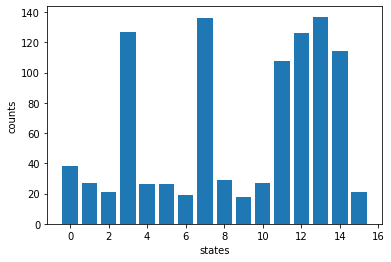

In [207]:
result=query_circuit_db(db, 4, 6,3)

## The Grover Operator Repetitions

T  : |0|1|2|
            
q0 : -C-C-C-
      | | | 
q1 : -Z-|-|-
        | | 
q2 : ---Z-|-
          | 
q3 : -----Z-

T  : |0|1|2|
qubits 4
db reads 2
T  : |0|1| 2 | 3 |4|5|    6    |7|    8     |9|   10    |11|    12    |13|   14    |15|    16    |17|   18    |19|    20    |21|   22    |23|    24    |25|   26    |27|    28    |29 |   30    |31|    32    |33 |   34    |35|36|37 |38 |39|40|   41    |42|    43    |44|   45    |46|    47    |48|   49    |50|    51    |52|   53    |54|    55    |56|   57    |58|    59    |60|   61    |62|    63    |64 |   65    |66|    67    |68 |   69    |70|71|
                                                                                                                                                                                                                                                                                                                                                                                                                

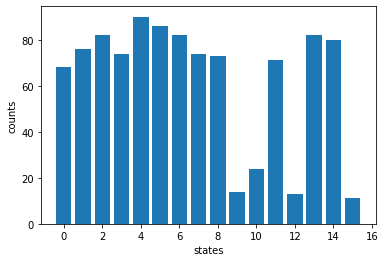

In [71]:
db=Circuit().cz(0,1).cz(0,2).cz(0,3)
result=query_circuit_db(db, 4, 4, 2)

T  : |0|
        
q0 : -C-
      | 
q1 : -Z-
        
q2 : -C-
      | 
q3 : -Z-

T  : |0|
qubits 4
db reads 1
T  : |0|1|2|3|    4    |5|    6     |7|    8    |9|    10    |11|   12    |13|    14    |15|   16    |17|    18    |19|   20    |21|    22    |23|   24    |25|    26    |27 |   28    |29|    30    |31 |   32    |33|34|
                                                                                                                                                                                                                          
q0 : -H-C-H-X-Rz(0.196)-C------------C------------------------C--------------------------C--------------------------C--------------------------C--------------------------C---------------------------C---X---------H-----
        |               |            |                        |                          |                          |                          |                          |                           |                   
q1 : -H-Z-H-X

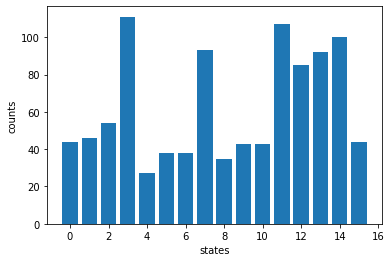

In [70]:
db=Circuit().cz(0,1).cz(2,3)
result=query_circuit_db(db, 4, 4)

T  : | 0 |
          
q0 : -Z---
      |   
q1 : -|-C-
      | | 
q2 : -|-Z-
      |   
q3 : -C---

T  : | 0 |
qubits 4
db reads 0
T  : |0|
        
q0 : -H-
        
q1 : -H-
        
q2 : -H-
        
q3 : -H-

T  : |0|
{11: 45, 13: 73, 15: 67, 14: 51, 8: 62, 0: 64, 1: 73, 2: 65, 4: 56, 12: 72, 5: 75, 10: 66, 7: 44, 3: 77, 9: 57, 6: 53}


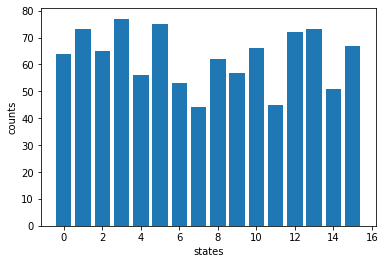

In [73]:
db=Circuit().cz(3,0).cz(1,2)
result=query_circuit_db(db, 4, 6)

In [ ]:
---------------------- end -----------------

Note on the controlled z gates used

ccz gate from https://www.researchgate.net/publication/312023141_Fast_microwave-driven_three-qubit_gates_for_cavity-coupled_superconducting_qubits

In [157]:
ccz=Circuit().cnot(1,2).ti(2).cnot(0,2).t(2).cnot(1,2).ti(2).cnot(0,2).t(1).t(2).cnot(0,1).t(0).ti(1).cnot(0,1)
print(ccz)

T  : |0|1 |2|3|4|5 |6|7|8 |9|
                             
q0 : ------C--------C-C-T--C-
           |        | |    | 
q1 : -C----|---C-T--|-X-Ti-X-
      |    |   |    |        
q2 : -X-Ti-X-T-X-Ti-X-T------

T  : |0|1 |2|3|4|5 |6|7|8 |9|


cccz gate from https://arxiv.org/pdf/2109.13223.pdf
cccz gate from https://quantumcomputing.stackexchange.com/questions/4078/how-to-construct-a-multi-qubit-controlled-z-from-elementary-gates

In [171]:
cccz=Circuit()
cccz=cccz.rz(0,np.pi/16).cnot(0,1).rz(1,-np.pi/16).cnot(0,1).rz(1,np.pi/16)
cccz=cccz.cnot(1,2).rz(2,-np.pi/16).cnot(0,2).rz(2,np.pi/16).cnot(1,2).rz(2,-np.pi/16).cnot(0,2).rz(2,np.pi/16)
cccz=cccz.cnot(2,3).rz(3,-np.pi/16).cnot(0,3).rz(3,np.pi/16).cnot(1,3).rz(3,-np.pi/16).cnot(0,3).rz(3,np.pi/16)
cccz=cccz.cnot(2,3).rz(3,-np.pi/16).cnot(0,3).rz(3,np.pi/16).cnot(1,3).rz(3,-np.pi/16).cnot(0,3).rz(3,np.pi/16)
print(cccz)

T  : |    0    |1|    2     |3|    4    |5|    6     |7|    8    |9|    10    |11|   12    |13|    14    |15|   16    |17|    18    |19|   20    |21|    22    |23|   24    |25|    26    |27|   28    |
                                                                                                                                                                                                        
q0 : -Rz(0.196)-C------------C------------------------C------------------------C--------------------------C--------------------------C--------------------------C--------------------------C------------
                |            |                        |                        |                          |                          |                          |                          |            
q1 : -----------X-Rz(-0.196)-X-Rz(0.196)-C------------|-----------C------------|--------------------------|------------C-------------|--------------------------|------------C-------------|--------

In [56]:
import numpy as np
# z opeator
arr_z=np.array([[1,0],[0,-1]])
arr_c=np.array([[1,0],[0,1]])

arr_cz=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])

Different trials of creating db 

In [51]:
mr=np.kron(arr_z,arr_c)

In [52]:
print(mr)

[[ 1  0  0  0]
 [ 0  1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0 -1]]


In [54]:
mr=np.kron(arr_c,arr_z)
print(mr)

[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0  1  0]
 [ 0  0  0 -1]]


In [63]:
arr_zz=np.kron(arr_z,arr_z)
print(arr_zz)

[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]]


In [61]:
arr_ccz=np.kron(arr_c,arr_cz)
print(arr_ccz)

[[ 1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 -1]]


In [64]:
arr_x=np.array([[0,1],[1,0]])
arr_i=np.array([[1,0],[0,1]])